In [13]:
#####################################################
##               Read bag from file                ##
#####################################################


# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
import argparse
# Import os.path for file path manipulation
import os.path

# Read from Stereo Module
# description="Read recorded bag file and display depth stream in jet colormap.
#              Remember to change the stream fps and format to match the recorded."


bag_input = '20220405_220626.bag'


# Create pipeline
pipeline = rs.pipeline()

# Create a config object
config = rs.config()

# Tell config that we will use a recorded device from file to be used by the pipeline through playback.
rs.config.enable_device_from_file(config, bag_input)

# Configure the pipeline to stream the depth stream
# Change this parameters according to the recorded bag file resolution
config.enable_stream(rs.stream.depth,848, 480,rs.format.z16, 30)
config.enable_stream(rs.stream.color,640, 480,rs.format.rgb8, 30)

# Start streaming from file
pipeline.start(config)

# Create opencv window to render image in
# cv2.namedWindow("Depth Stream", cv2.WINDOW_AUTOSIZE)

# Create colorizer object
colorizer = rs.colorizer()

profile = pipeline.get_active_profile()
print(profile)
depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
print("depth_profile",depth_profile)
color_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))
print("color_profile", color_profile)
depth_intrinsics = depth_profile.get_intrinsics()
print(depth_intrinsics)
color_intrinsics = color_profile.get_intrinsics()
print(color_intrinsics)
w, h = depth_intrinsics.width, depth_intrinsics.height
print(w,h)

# Streaming loop
# while True:
#     # Get frameset of depth
#     frames = pipeline.wait_for_frames()

#     # Get depth frame
#     depth_frame = frames.get_depth_frame()
    
#     # Get color frame
#     color_frame = frames.get_color_frame()

#     # Colorize depth frame to jet colormap
#     depth_color_frame = colorizer.colorize(depth_frame)

#     # Convert depth_frame to numpy array to render image in opencv
#     depth_color_image = np.asanyarray(depth_color_frame.get_data())
    
#     # get color frame
#     color_image = np.asanyarray(color_frame.get_data())

#     # Render image in opencv window
#     cv2.imshow("Depth Stream", depth_color_image)
#     cv2.imshow("Color Stream", color_image)
#     key = cv2.waitKey(1)
#     # if pressed escape exit program
#     if key == 27:
#         cv2.destroyAllWindows()
#         break



depth_profile <pyrealsense2.video_stream_profile: Depth(0) 848x480 @ 30fps Z16>
color_profile <pyrealsense2.video_stream_profile: Color(0) 640x480 @ 30fps RGB8>
[ 848x480  p[426.785 234.17]  f[419.127 419.127]  Brown Conrady [0 0 0 0 0] ]
[ 640x480  p[323.426 249.374]  f[607.323 606.302]  Inverse Brown Conrady [0 0 0 0 0] ]
848 480


depth_intrinsics: [0.0, 0.0, 0.0, 0.0, 0.0]
color_intrinsics: [ 640x480  p[323.426 249.374]  f[607.323 606.302]  Inverse Brown Conrady [0 0 0 0 0] ]
obj_points []
img_points []


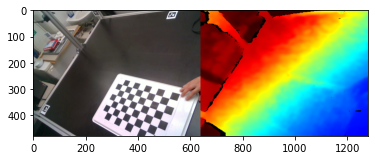

In [9]:
# 2. Object Twin (workload 3 students):
# In this exercise, we will load a realsense-viewer rosbag recording, then use opencv and pyrender to create a twin of a moving checkerboard.

# Loading color and depth data:
# Use pyrealsense2 to read the bagfile and acquire color, depth, aligned depth to color, color camera intrinsics, depth camera intrinsics. (Show the images in a loop using cv2.imshow)
#
# Checkerboard detection and tracking:
# The checkerboard has a 6x9 pattern where each square has an edge length of 4 cm.
# Using opencv we want Find its corners (use cv2.findChessboardCorners, and cv2.cornersSubPix). then use cv2.drawChessboardCorners to overlay the detections on the colored image
# From the previous step, you will have 2D/3D correspondences for the corners. Use cv2.solvePnP to estimate the object to camera translation and rotation vectors.
# Extra: Use opencv drawing utils and perspective projection function to draw a 3D axis, and a cropping mask for the board. Useful functions here could be cv2.line,cv2.projectPoints,cv2.fillPoly.
#
# Modeling the checkerboard in pyrender:
# Using pyrender create a scene with camera and a Box mesh corresponding to the checkerboard.
# Notes:
# You will need to scale the box and shift its center to match the checkerboard 3d coordinate system in opencv
# To convert from opencv camera to pyrender camera in you system you may need to rotate your objects by 90 degees around the X-axis (depending on your implementation)
#
# Visualization:
# In the loop, update the mesh pose with the updated pose of the checkerboard
# Compare the rendered depth value to the actual algined_depth values we got from realsense.


# First import library
import matplotlib.pyplot as plt 
from matplotlib.pyplot import get
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
from skimage.color import rgb2gray

def get_color_images(frames):
    # Get color frame
    color_frame = frames.get_color_frame()
    color_image = np.asanyarray(color_frame.get_data())
    # Create colorizer object
    colorizer = rs.colorizer()
    return color_image, colorizer

def get_depth_images(frames, colorizer):
    # Get depth frame
    depth_frame = frames.get_depth_frame()
    # Colorize depth frame to jet colormap
    depth_color_frame = colorizer.colorize(depth_frame)
    # Convert depth_frame to numpy array to render image in opencv
    depth_color_image = np.asanyarray(depth_color_frame.get_data())
    depth_image = np.asanyarray(depth_frame.get_data())
    return depth_color_image, depth_image

def align_images(frames, color_image, colorizer):
    # Create alignment primitive with color as its target stream:
    align = rs.align(rs.stream.color)
    frames = align.process(frames)

    # Update color and depth frames:
    aligned_depth_frame = frames.get_depth_frame()
    colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

    # Show the two frames together:
    images = np.hstack((color_image, colorized_depth))
    
    plt.imshow(images)
    
def find_points(image_gray, image):
    PATTERN_SIZE = (9, 6)
    obj_points = []
    img_points = []

    # Assumed object points relation
    a_object_point = np.zeros((PATTERN_SIZE[1] * PATTERN_SIZE[0], 3),
                              np.float32)
    a_object_point[:, :2] = np.mgrid[0:PATTERN_SIZE[0],
                                     0:PATTERN_SIZE[1]].T.reshape(-1, 2)

    # Termination criteria for sub pixel corners refinement
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
                     30, 0.001)

#     print('Finding points ', end='')
    debug_images = []
    found, corners = cv2.findChessboardCorners(image_gray, PATTERN_SIZE, None)
    if found:
        obj_points.append(a_object_point)
        cv2.cornerSubPix(image_gray, corners, (11, 11), (-1, -1), stop_criteria)
        img_points.append(corners)
        cv2.drawChessboardCorners(image, (9, 6), corners, found)
        cv2.imshow('img',image)
#         cv2.waitKey(0)

#         print('.', end='')
#     else:
#         print('-', end='')

#     print('\nWas able to find points in %s images' % len(img_points))
        
    return obj_points, img_points

rosbag_path = '20220405_220626.bag'
# Create pipeline
pipeline = rs.pipeline()
# Create a config object
config = rs.config()
# Tell config that we will use a recorded device from file to be used by the pipeline through playback.
config.enable_device_from_file(rosbag_path)
# Configure the pipeline to stream the depth stream
# Change this parameters according to the recorded bag file resolution
config.enable_stream(rs.stream.depth,848, 480,rs.format.z16, 30)
config.enable_stream(rs.stream.color,640, 480,rs.format.rgb8, 30)
# Start streaming from file
pipeline.start(config)

# Streaming loop
while True:
    # Get frameset of depth
    frames = pipeline.wait_for_frames()
    color_image, colorizer = get_color_images(frames)
    
    grayscale_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    obj_points, img_points = find_points(grayscale_image, color_image)

    depth_color_image, depth_image = get_depth_images(frames, colorizer)

    # Render image in opencv window
    cv2.imshow("Color Stream", color_image)
    cv2.imshow("Depth Stream", depth_color_image)
    cv2.imshow("Grayscale Stream", grayscale_image)
    
    key = cv2.waitKey(1)
    # if pressed escape exit program
    if key == 27:
        cv2.destroyAllWindows()
        break
        
# the aligned image is selected by the time when we press 'Esc'
align_images(frames, color_image, colorizer)

profile = pipeline.get_active_profile()

depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
color_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))

depth_intrinsics = depth_profile.get_intrinsics()
print('depth_intrinsics:', depth_intrinsics.coeffs)
color_intrinsics = color_profile.get_intrinsics()
print('color_intrinsics:', color_intrinsics)

print('obj_points', obj_points)
print('img_points', img_points)

In [10]:
camera_matrix_ori = np.array([[607.323, 0.0, 323.426], [0.0, 606.302, 249.374], [0.0, 0.0, 1.0]]
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (640, 480), camera_matrix_ori, [0.0, 0.0, 0.0, 0.0, 0.0])
print('camera_matrix:', camera_matrix)
print('dist_coefs', dist_coefs)
# obj_points = np.asarray(obj_points)
# img_points = np.asarray(img_points)

# ret, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_matrix, dist_coefs,None, None, False, cv2.SOLVEPNP_ITERATIVE)

# print('rvec', rvec)
# print('tvec', tvec)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'calibrateCamera'
> Overload resolution failed:
>  - cameraMatrix is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'cameraMatrix'


In [14]:
def find_points(image_gray, image):
    PATTERN_SIZE = (7, 7)
    obj_points = []
    img_points = []

    # Assumed object points relation
    a_object_point = np.zeros((PATTERN_SIZE[1] * PATTERN_SIZE[0], 3),
                              np.float32)
    a_object_point[:, :2] = np.mgrid[0:PATTERN_SIZE[0],
                                     0:PATTERN_SIZE[1]].T.reshape(-1, 2)

    # Termination criteria for sub pixel corners refinement
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
                     30, 0.001)

#     print('Finding points ', end='')
    debug_images = []
    found, corners = cv2.findChessboardCorners(image_gray, PATTERN_SIZE, None)
    if found:
        obj_points.append(a_object_point)
        cv2.cornerSubPix(image_gray, corners, (11, 11), (-1, -1), stop_criteria)
        img_points.append(corners)
        cv2.drawChessboardCorners(image, (7,7), corners, found)
        cv2.imshow('img',image)
        cv2.waitKey(0)

#         print('.', end='')
#     else:
#         print('-', end='')

#     print('\nWas able to find points in %s images' % len(img_points))
        
    return obj_points, img_points

image = cv2.imread('./Chessboard.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
obj_points, img_points = find_points(image_gray, image)
print(obj_points)
print(img_points)

[array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [0., 5., 0.],
       [1., 5., 0.],
       [2., 5., 0.],
       [3., 5., 0.],
       [4., 5., 0.],
       [5., 5., 0.],
       [6., 5., 0.],
       [0., 6., 0.],
       [1., 6., 0.],
       [2., 6., 0.],
       [3., 6., 0.],
       [4., 6., 0.],
       [5., 

In [13]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2017 Intel Corporation. All Rights Reserved.

#####################################################
##              Align Depth to Color               ##
#####################################################

# First import the library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2

rosbag_path = '20220405_220626.bag'
# Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()

config.enable_device_from_file(rosbag_path)

# found_rgb = False
# for s in device.sensors:
#     if s.get_info(rs.camera_info.name) == 'RGB Camera':
#         found_rgb = True
#         break
# if not found_rgb:
#     print("The demo requires Depth camera with Color sensor")
#     exit(0)

config.enable_stream(rs.stream.depth,848, 480,rs.format.z16, 30)
config.enable_stream(rs.stream.color,640, 480,rs.format.rgb8, 30)

# if device_product_line == 'L500':
#     config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
# else:
#     config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# We will be removing the background of objects more than
#  clipping_distance_in_meters meters away
# clipping_distance_in_meters = 1 #1 meter
# clipping_distance = clipping_distance_in_meters / depth_scale

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)

# Streaming loop
try:
    while True:
        # Get frameset of color and depth
        frames = pipeline.wait_for_frames()
        # frames.get_depth_frame() is a 640x360 depth image

        # Align the depth frame to color frame
        aligned_frames = align.process(frames)

        # Get aligned frames
        aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frames.get_color_frame()

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Remove background - Set pixels further than clipping_distance to grey
#         grey_color = 255
#         depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
#         bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)

        # Render images:
        #   depth align to color on left
        #   depth on right
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        images = np.hstack((bg_removed, depth_colormap))

        cv2.namedWindow('Align Example', cv2.WINDOW_NORMAL)
        cv2.imshow('Align Example', images)
        key = cv2.waitKey(1)
        # Press esc or 'q' to close the image window
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
finally:
    pipeline.stop()

Depth Scale is:  0.0010000000474974513
